# Parametric Distributions

```{admonition} Learning Objectives
:class: tip
* Identify several parametric distributions and their properties.
* Select parameters to align a parametric distribution to the observed histogram.
```

In section [Sound Level Distribution](../stats_01_random_variables.ipynb) we looked at the empirical distribution of the sound levels dataset through the lens of the histogram. Often (but not always) the distribution's shape can be described by a function with a few parameters, and those parameters can have an interpretable meaning. 

We will look at a segment of background sound from the [Orcasound](https://www.orcasound.net/) hydrophone network.

## Reading Data

In [29]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&confirm=t&id=1466snzjsXPVTlKnzkkCkdOgwoO5Zvutq' -O background.wav

--2025-05-16 03:55:16--  https://docs.google.com/uc?export=download&confirm=t&id=1466snzjsXPVTlKnzkkCkdOgwoO5Zvutq
Resolving docs.google.com (docs.google.com)... 142.250.217.78, 2607:f8b0:400a:803::200e
Connecting to docs.google.com (docs.google.com)|142.250.217.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1466snzjsXPVTlKnzkkCkdOgwoO5Zvutq&export=download [following]
--2025-05-16 03:55:16--  https://drive.usercontent.google.com/download?id=1466snzjsXPVTlKnzkkCkdOgwoO5Zvutq&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.217.65, 2607:f8b0:400a:80b::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.217.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5759054 (5.5M) [audio/wav]
Saving to: ‘background.wav’

background.wav      100%[===================>]   5.49M  13.6MB/s    in 0.4s    

20

In [30]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np

In [31]:
from IPython.display import Audio

In [32]:
Audio("background.wav", rate=48000)

In [33]:
from scipy.io import wavfile

In [34]:
# reading background data
samplerate, sound = wavfile.read('background.wav')
print("Sample rate: "+ str(samplerate))

Sample rate: 48000


## Computing Sound Levels

We will compute the (relative) sound levels for each **segment of 0.1s**:

1. we will split the signal into 0.1s segments
2. compute the Root Mean Squares of the signal
3. convert to dB values

In [35]:
# length of window in time
win_len = 0.1

# truncate the signal to be exact number of seconds
len_trunc = len(sound)-len(sound)%samplerate

# number of windows
n_win = len_trunc/samplerate/win_len

# split signal in n_win
sound_split = np.split(sound[:len_trunc], n_win)

In [36]:
# we calculate RMS for each window
RMS = [np.sqrt(np.mean(np.square(group.astype('float')))) for group in sound_split]

# convert to sound levels
sound_levels = 20*np.log10(RMS)

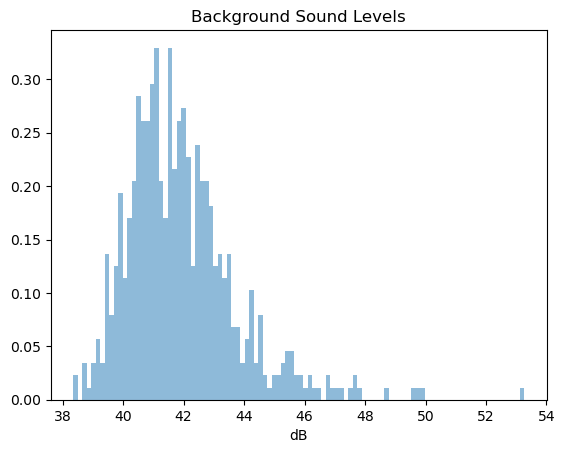

In [37]:
# visualize the histogram of the log values
h = plt.hist(sound_levels, bins=100, density=True, alpha=0.5)
_ = plt.title("Background Sound Levels")
_ = plt.xlabel("dB")

:::{note}
The range of the levels are lower than what we would find in a dataset. The reason is that the hydrophone is not calibrated, hence these are relative levels. The true distribution will be shifted to the right. Here we focus on the shape of the distribution.
:::

## Normal Distribution

A popular example is the Normal (Gaussian) distribution, which is characterized by the bell curve and its mean and variance. In the context of ocean acoustics, we can assume that background noise (in the absence of distinct strong noise sources) follows normal distribution. 

We observe that the histogram is not a "perfect" bell curve, partially because there are some sounds of waves. Regardless, let's try to see how closely we can describe it with a normal distribution. 

First, we will calculate the mean and the variance of the observations, and we will overlay the normal density curve with those parameters on the histogram.

In [38]:
mean = np.mean(sound_levels)
std = np.std(sound_levels)

In [39]:
import scipy.stats as stats

gaussian_density = stats.norm.pdf(h[1], loc=mean, scale=std)

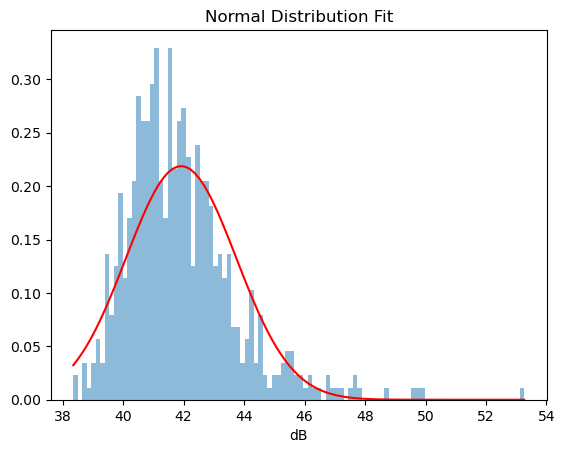

In [40]:
# visualize the histogram of the log values
h = plt.hist(sound_levels, bins=100, density=True, alpha=0.5)
_ = plt.plot(h[1], gaussian_density, 'r')
_ = plt.title("Normal Distribution Fit")
_ = plt.xlabel("dB")

## Skew Normal Distribution

It is obvious that the distribution of the sound levels is not symmetric. The right tail corresponds to the rare louder events. Skew normal distribution is an example of a distribution which has a parameter called "shape" which introduces skew to the distribution. If it is positive, it is skewed to the right; if it is negative it is skewed to the left, and zero corresponds to normal distribution.

In [41]:
# construct the density with a shape parameter a=2
skewnormal_density = stats.skewnorm.pdf(h[1], a=2, scale=std, loc=mean)

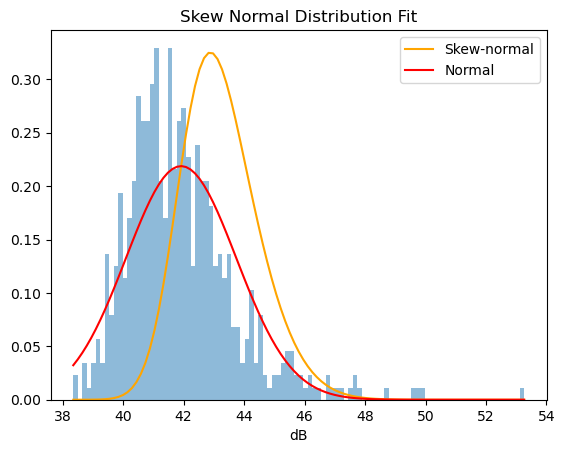

In [42]:
h = plt.hist(sound_levels, bins=100, density=True, alpha=0.5)
plt.title("Skew Normal Distribution Fit")
_ = plt.plot(h[1], skewnormal_density, color="orange", label="Skew-normal")
_ = plt.plot(h[1], gaussian_density, 'r', label="Normal")
_ = plt.legend()
_ = plt.xlabel("dB")

We can see that the shape of this distribution is slightly skewed to the right but still does not fit quite right.

## Fitting A Distribution

While for a distribution like the normal distribution it is intuitive to understand that the sample mean and standard deviation can be used to select the right parameters for a Gaussian model, determining the parameters of the Skew Normal distribution can be more challenging.

If we have a substantially large sample from a distribution, we expect that the analytical distribution matches the empirical one. We expect that its probability density will be close to the outline of the histogram of the sample. Of course, we may need a very large sample to observe values in the tails of the distribution.

### Skew-normal Parameter Fitting Widget

We will demonstrate the effect of the parameters of the skew-normal distribution on its shape and how that can change the "fit" to empirical distribution. In the absence of other knowledge, we will start with a skew-normal distribution with zero shape, offset equal to the mean, and scale equal to the standard deviation, i.e. a normal distribution

In [43]:
from ipywidgets import interact
import ipywidgets as widgets

In [44]:
shape_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=10.0,
    step=0.5,
    description='Shape:',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

scale_slider = widgets.FloatSlider(
    value=std,
    min=std - 0.1,
    max=std + 0.1,
    step=0.01,
    description='Scale:',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

offset_slider = widgets.FloatSlider(
    value=mean,
    min=mean-2,
    max=mean+2,
    step=0.01,
    description='Offset:',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)


In [45]:
def plot_skewnormal_density(a, scale, offset):
  h = plt.hist(sound_levels,bins=100, density=True, alpha=0.5)
  skewnormal_density_density = stats.skewnorm.pdf(h[1], a=a, scale=scale, loc=offset)
  plt.plot(h[1], skewnormal_density)
  plt.title("Fitting a Skew Normal Distribution")

In [46]:
out = interact(plot_skewnormal_density, a = shape_slider, scale = scale_slider, offset = offset_slider)

interactive(children=(FloatSlider(value=0.0, description='Shape:', max=10.0, step=0.5), FloatSlider(value=1.82…

`````{admonition} Exercise
Manipulate the parameters to achieve a better fit.
`````

You may have observed that it is not entirely straightforward to find a good fit. Simply increasing the shape parameter is not enough. It is not entirely clear whether to capture some of the values in the tail or in the peaks. In section [Parameter Estimation](./stats_04_parameter_estimation.ipynb) we will discuss how to do this quantitatively and automatically.

:::{important}
Why fit a parametric distribution?
* Describe the distribution of many observations only with a few parameters
* Calculate probability of certain events with an analytical function
* Approximate values of interpretable parameters
* Derive properties of the distribution
* Compare changes in distribution
::: 

## Other Distributions

### Cauchy Distribution

The Cauchy distribution is popular example of a distribution which at first sight seems to have a "bell shape" similar to that of a normal distribution, however, its tails are "fatter", i.e. events in those tails are more common to occur than events in the tails of the normal distribution. While the normal distribution can be described by its mean and standard deviation, the Cauchy distribution is a pathological example of a distribution without finite expected value and variance. 

The Cauchy distribution instead can be described by its **median** and the **interquartile range** (the range corresponding to the middle 50% of the observations). 

In [47]:
cauchy_density = stats.cauchy.pdf(h[1],np.median(sound_levels), stats.iqr(sound_levels)/2)

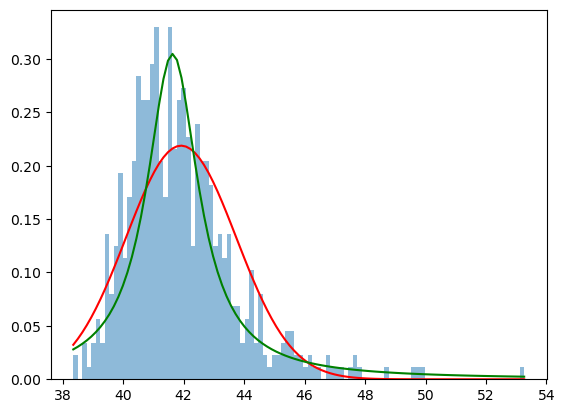

In [48]:
# visualize the histogram of the log values
h = plt.hist(sound_levels, bins=100, density=True, alpha=0.5)
plt.plot(h[1], gaussian_density, 'r')
plt.plot(h[1], cauchy_density, 'g')


We can see that the right-hand-side tail is higher than the tail of the normal distribution and in this case seems to better capture the outliers (which in this case correspond to louder events in comparison to ambient noise).

### Logistic Distribution

Logistic distribution is another example of a distribution with thicker tails, however, it has better properties: its mean and variance are finite. It can be described by its mean and scale $(\sqrt{3}std/\pi )$.

In [49]:
import math
logistic_density = stats.logistic.pdf(h[1], mean, std/math.pi*math.sqrt(3))

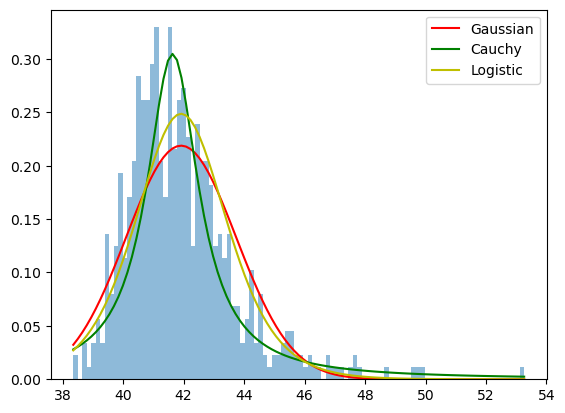

In [50]:
# visualize the histogram of the log values
h = plt.hist(sound_levels, bins=100, density=True, alpha=0.5)
plt.plot(h[1], gaussian_density, 'r')
plt.plot(h[1], cauchy_density, 'g')
plt.plot(h[1], logistic_density, 'y')
plt.legend(["Gaussian", "Cauchy", "Logistic"])

The tails are just slightly higher than the tails of the normal distribution, but it overal captures more of the cental data.

### Laplace Distribution

Yet another example of a symmetric distribution is Laplace. Laplace distribution is characterized by a sharper peak.

In [51]:
laplace_density = stats.laplace.pdf(h[1], loc=mean, scale=std)

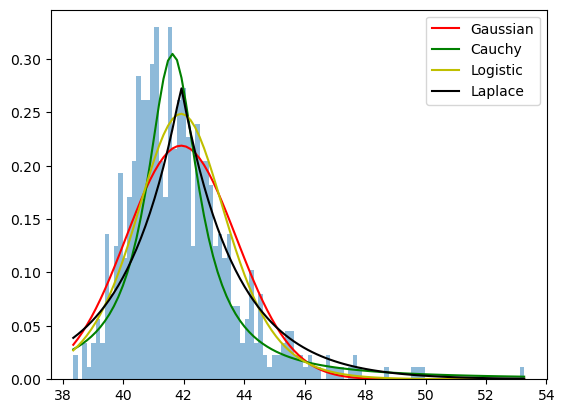

In [52]:
# visualize the histogram of the log values
h = plt.hist(sound_levels, bins=100, density=True, alpha=0.5)
plt.plot(h[1], gaussian_density, 'r')
plt.plot(h[1], cauchy_density, 'g')
plt.plot(h[1], logistic_density, 'y')
plt.plot(h[1], laplace_density, 'k')
plt.legend(["Gaussian", "Cauchy", "Logistic", "Laplace"])

### Gamma Distribution



The left tail has cut-off threshold due to the properies of the hydrophone. We can describe this pattern with Gamma distribution which can have a non-symmetric shape. 



There are several parameters which describe a Gamma distribution: **shape**, **scale**, and **offset**. The shape determines the **skewness**, and for that we need to estimate the sample skewness from the sample. Once the shape is known the sample mean and standard deviation can be used to estimate the offset and scale.

$\alpha = \frac{4}{skeweness^2}$

$offset = \mu - \sigma \sqrt{\alpha}$

$scale = \frac{\sigma^2}{\mu - offset}$

In [53]:
# calculate skewness
sk = stats.skew(sound_levels, bias=True)

In [54]:
# estimate parameters
a = 4/(sk**2)
offset = mean - std*np.sqrt(a)
offset = min(sound_levels) 
scale = std**2/(mean - offset)
a = 3 #! set it to 4 as it looks a bit better

In [55]:
gamma_density = stats.gamma.pdf(h[1], a=a, scale=scale, loc=offset)

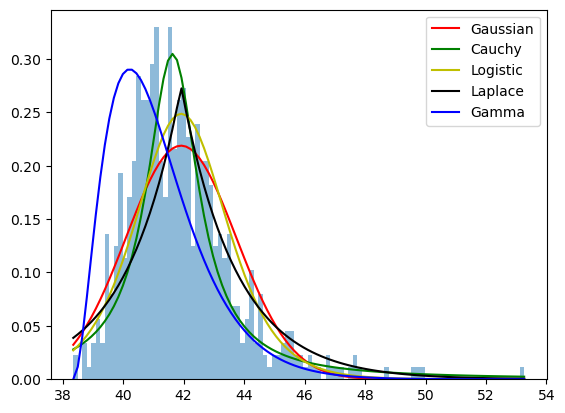

In [56]:
# visualize the histogram of the log values
h = plt.hist(sound_levels, bins=100, density=True, alpha=0.5)
plt.plot(h[1], gaussian_density, 'r')
plt.plot(h[1], cauchy_density, 'g')
plt.plot(h[1], logistic_density, 'y')
plt.plot(h[1], laplace_density, 'k')
plt.plot(h[1], gamma_density, 'b')
plt.legend(["Gaussian", "Cauchy", "Logistic", "Laplace", "Gamma"])

:::{note}
We can see that all these distributions fit the data to some extent but have: 

* varying sharpness of the peak
* varying thickness of the tails
* varying skewness
:::

```{admonition} See also
:class: seealso

Other popular distributions:
* exponential: describing waiting times between events
* Poisson: describing number of events
* Mixture of Gaussians: multimodal distributions describing mixture of event types
* Binomial/Multinomial: describing proportions 
* Dirichlet: describing distributions of histograms
```